## Preprocessing

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 128, 128, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

(656, 128, 128, 1) (656, 128, 128, 1)


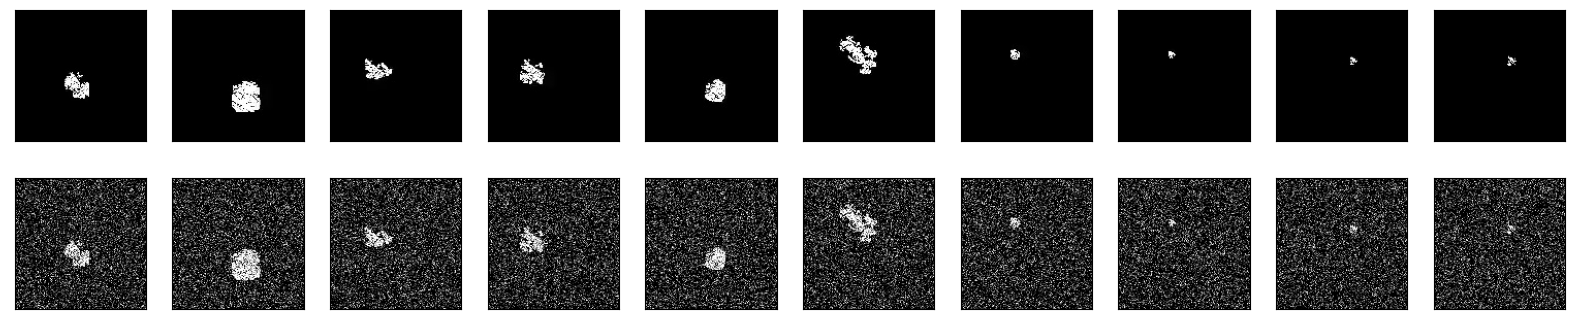

In [150]:
#loading in the data

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
data = [] 

for i in range(41):
    for j in range(16):
        image_name = 'video%s_frame_%s.jpg' % (i,j)
        im = mpimg.imread('%s' % (image_name)).flatten()
        #plt.imshow(im)
        #plt.show()   #these commented out lines of code will print out all the images
        im = cv2.imread(image_name, 0)  #read image as grayscale. Set second parameter to 1 if rgb is required 
        data.append(im)#value of 0 = black, 255 = white
data = np.asarray(data)  


test_data = []
for i in range(8):
    for j in range(16):
        image_name = 'video%s_frame_%s.jpg' % (i+41,j)
        im = mpimg.imread('%s' % (image_name)).flatten()
        #plt.imshow(im)
        #plt.show()   
        im = cv2.imread(image_name, 0)
        test_data.append(im)
        
test_data = np.asarray(test_data)

#splitting the data into timesteps of 4 images
#i.e give the training the first 3 images and predict the 4th 
#validation data will have the final image in the 4 image time step
#Hence validation data should have every 4th image
n = 4
validation_data = preprocess(data[n-1::n]) #validation will be every 4th frame starting from the 4th
test_validation_data = preprocess(test_data[n-1::n])

#preprocess the rest of the data
data = preprocess(data)
test_data = preprocess(test_data)

#add noise
noisy_data = noise(data)
noisy_test_data = noise(test_data) 

#display images
display(data, noisy_data)

#arrays to separate images into 3 time step batches 
#do this by reshaping the array then removing the 4th image
noisy_data = np.reshape(noisy_data, (164,4,128,128,1)) 
noise_data = []
for i in range(len(noisy_data)):
    noise_data.append(noisy_data[i,:3,:,:,:])
noise_data = np.array(noise_data)

#do the same for the test data
noisy_test_data = np.reshape(noisy_test_data, (32,4,128,128,1))
test_data = np.reshape(test_data, (32,4,128,128,1))
test_data1 = []
noise_test_data1 = []
for i in range(len(noisy_test_data)):
    test_data1.append(test_data[i,:3,:,:,:])
    noise_test_data1.append(noisy_test_data[i,:3,:,:,:])
test_data1 = np.array(test_data1)
noise_test_data1 = np.array(noise_test_data1)

## The Model

In [175]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import numpy as np
import pylab as plt


In [87]:
#Encoder part of model
cnn = keras.models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), strides= 2, activation="relu", padding="same", input_shape = (128,128,1)))
cnn.add(layers.MaxPooling2D((2, 2), padding="same"))
cnn.add(layers.Conv2D(32, (3, 3),strides= 2, activation="relu", padding="same"))
#cnn.add(layers.MaxPooling2D((2, 2), padding="same"))
cnn.add(layers.Conv2D(1,(3,3), strides=2, activation ="relu", padding="same"))
cnn.add(layers.Flatten())
cnn.compile(optimizer = "adam", loss = "binary_crossentropy")
cnn.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 8, 1)           289       
                                                                 
 flatten_15 (Flatten)        (None, 64)                0         
                                                                 
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
___________________________________________________

In [131]:
#LSTM part of model
lstm = keras.models.Sequential()
lstm.add(layers.LSTM(64, return_sequences= True, input_shape=(3,64)))
lstm.add(layers.LSTM(32, return_sequences= False))
lstm.compile(optimizer = "adam", loss = "binary_crossentropy")
lstm.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 3, 64)             33024     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
Total params: 45,440
Trainable params: 45,440
Non-trainable params: 0
_________________________________________________________________


In [132]:
#Decoder part of model
cnn2 = keras.models.Sequential()
cnn2.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", input_shape = (8,8,1)))
cnn2.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
cnn2.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
cnn2.add(layers.Conv2DTranspose(1, (3, 3), strides=2, activation="relu", padding="same"))

cnn2.compile(optimizer = "adam", loss = "binary_crossentropy")
cnn2.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 32)       320       
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 32, 32, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 64, 64, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 128, 128, 1)      289       
 Transpose)                                                      
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-tra

In [133]:
#Dense part of model
dense = keras.models.Sequential()
dense.add(layers.Dense(64, activation = 'relu'))

In [185]:
from tensorflow.keras.models import Model
#putting sections together
main_input = layers.Input(shape = (3,128,128,1))

model = layers.TimeDistributed(cnn)(main_input)
model = lstm(model)
model = dense(model)
model = layers.Reshape((8,8,1))(model)
model = cnn2(model)

final_model = Model(inputs = main_input, outputs = model)
final_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['mse', metrics.RootMeanSquaredError()])
final_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 3, 128, 128, 1)]  0         
                                                                 
 time_distributed_66 (TimeDi  (None, 3, 64)            9857      
 stributed)                                                      
                                                                 
 sequential_39 (Sequential)  (None, 32)                45440     
                                                                 
 sequential_41 (Sequential)  (None, 64)                2112      
                                                                 
 reshape_26 (Reshape)        (None, 8, 8, 1)           0         
                                                                 
 sequential_40 (Sequential)  (None, 128, 128, 1)       19105     
                                                          

In [186]:
print(np.shape(noise_data), np.shape(validation_data))
print(np.shape(noise_test_data1), np.shape(test_validation_data))
history = final_model.fit(
    x=noise_data,
    y=validation_data,
    epochs=50,
    batch_size=164,
    shuffle=True,
    validation_data=(test_data1, test_validation_data)
)

(164, 3, 128, 128, 1) (164, 128, 128, 1)
(32, 3, 128, 128, 1) (32, 128, 128, 1)
Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.0089 - mse: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0074 - val_mse: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 2/50
1/1 [==============================] - 1s 715ms/step - loss: 0.0095 - mse: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 3/50
1/1 [==============================] - 1s 956ms/step - loss: 0.0088 - mse: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 4/50
1/1 [==============================] - 1s 640ms/step - loss: 0.0088 - mse: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0854
Epoch 5/50
1/1 [==============================] - 1s 601ms/step - loss: 0.0090 - mse: 0.0090 - root_mean_squared_er

1/1 [==============================] - 0s 498ms/step - loss: 0.0082 - mse: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 42/50
1/1 [==============================] - 1s 511ms/step - loss: 0.0082 - mse: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 43/50
1/1 [==============================] - 0s 482ms/step - loss: 0.0082 - mse: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 44/50
1/1 [==============================] - 0s 491ms/step - loss: 0.0081 - mse: 0.0081 - root_mean_squared_error: 0.0903 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 45/50
1/1 [==============================] - 0s 488ms/step - loss: 0.0081 - mse: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0073 - val_mse: 0.0073 - val_root_mean_squared_error: 0.08

## Analysis

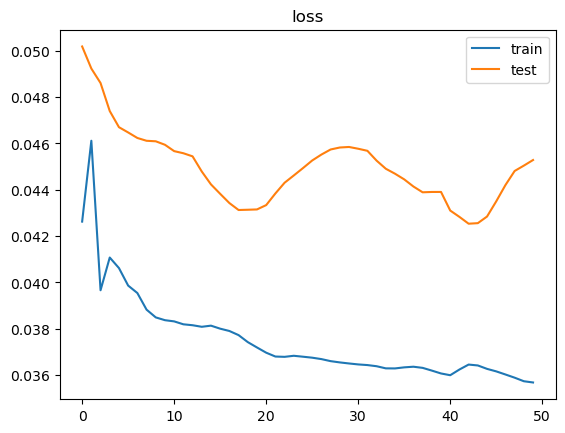

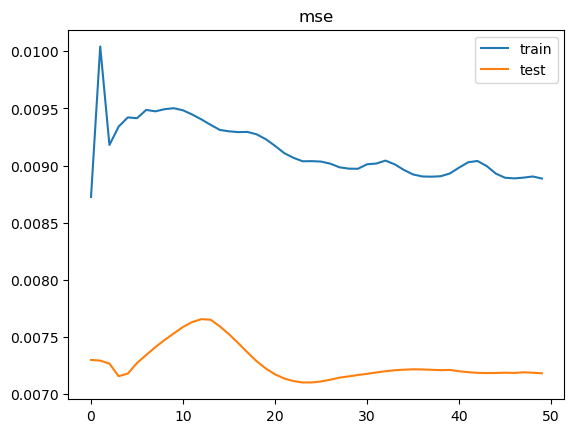

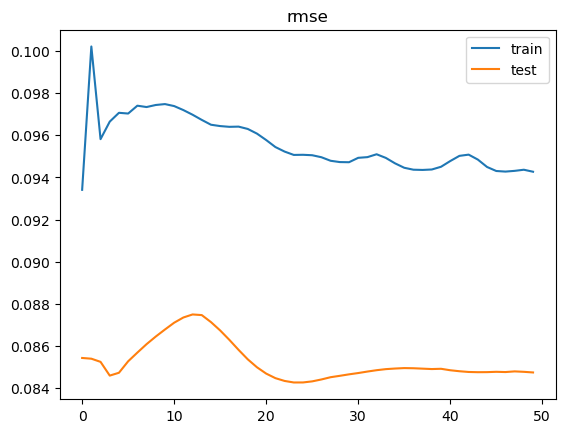

In [184]:
#For binary cross entropy loss function
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('mse')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

plt.title('rmse')
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show()

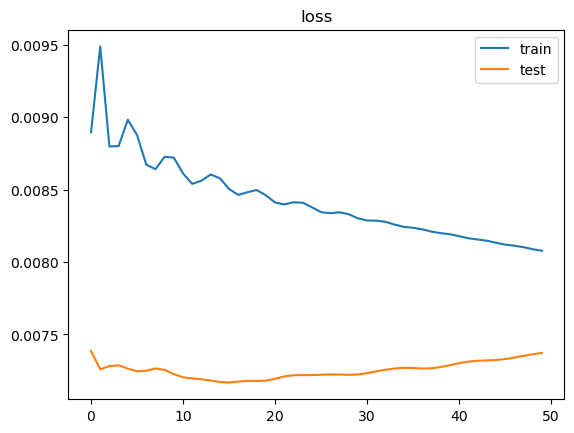

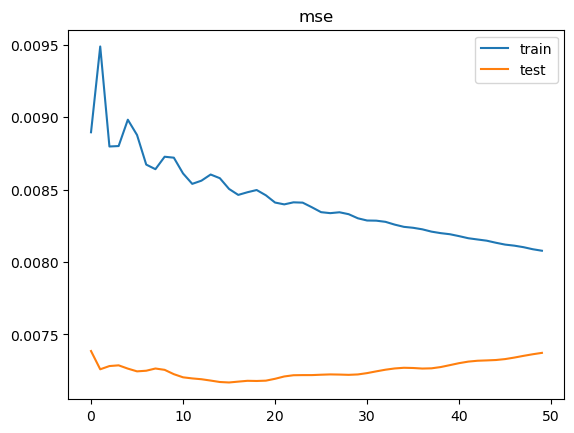

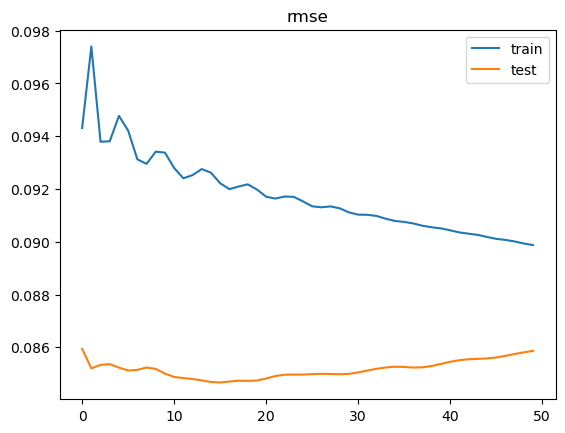

In [187]:
#For mse loss function
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('mse')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

plt.title('rmse')
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show()

Near 50 epochs as loss starts to increase again for test and training data.

Changed Batch size to be 164 and decreased the entire time (no increase in loss/val_loss around epoch 50)

Using loss function of binary crossentropy we get a 
loss = 0.0357     and val_loss = 0.0453
MSE = 0.0089      and val_MSE = 0.0072
RMSE = 0.0943     and val_RMSE = 0.0847

Now changing loss function to mse 
loss = 0.0081     and val_loss = 0.0074
MSE = 0.0081      and val_MSE = 0.0074
RMSE = 0.0899     and val_RMSE = 0.0859


Using the loss function mse we can see that the model overfits after 50 epochs as the metrics for the test data begin increasing around epoch 20 (as seen in the graphs) while the training metrics continue to decrease.

1/1 [==============================] - 0s 59ms/step
(32, 128, 128, 1)
(32, 3, 128, 128, 1)


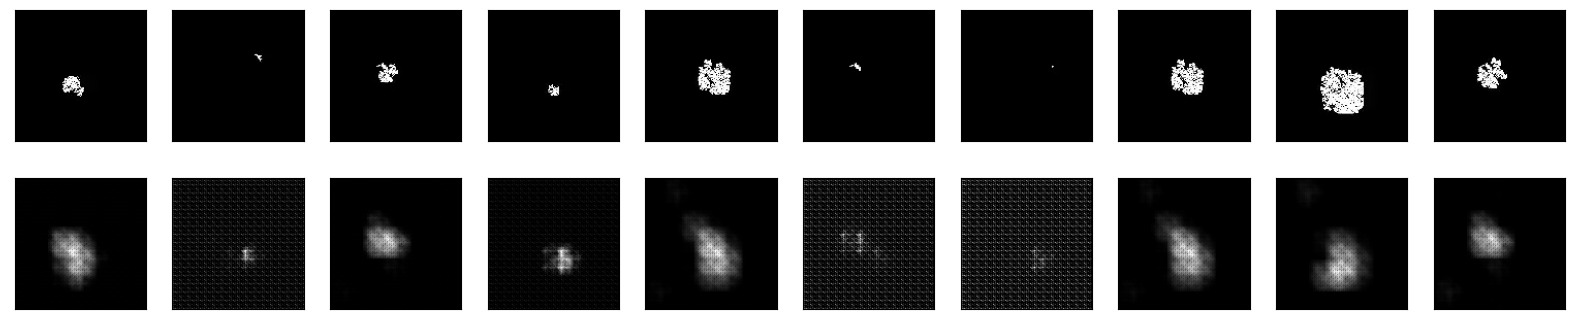

In [161]:
#For binary cross entropy as the loss function

predictions = final_model.predict(test_data1)

print(np.shape(predictions))
print(np.shape(test_data1))
display(test_validation_data, predictions)

1/1 [==============================] - 1s 634ms/step
(32, 128, 128, 1)
(32, 3, 128, 128, 1)


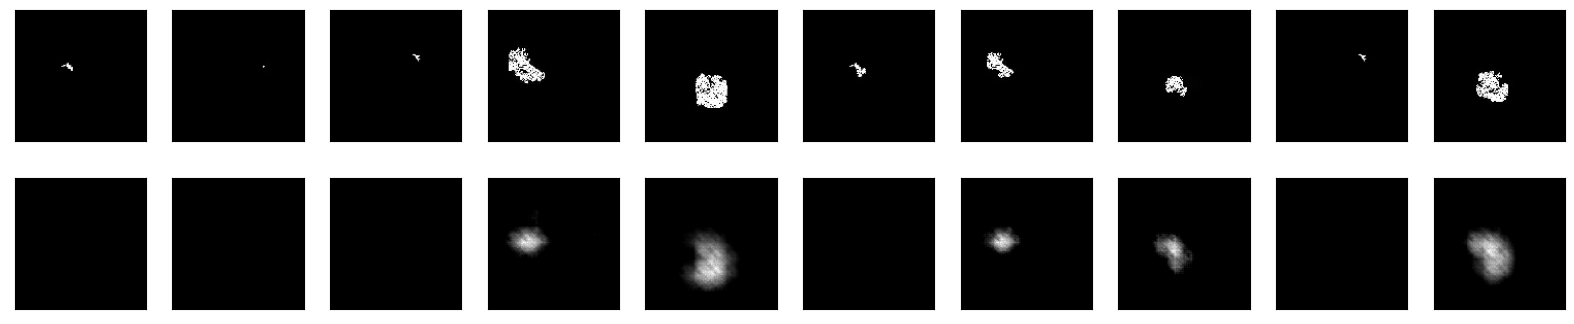

In [173]:
#For MSE as the loss function
predictions = final_model.predict(test_data1)

print(np.shape(predictions))
print(np.shape(test_data1))
display(test_validation_data, predictions)

Model does a good job at predicting next frame when there is a lot of white space, but struggles when the whitespace is small.

Changing the batch size has made it better at dealing with low white space images (still not great though)

When changing the loss function to mse it does slightly better with larger whitespaces but much worse with small amounts of white space.